based on https://arxiv.org/pdf/2002.08232.pdf

In [ ]:
!pip install pytorch-metric-learning > /dev/null

# probably not needed
# although can try knn
!pip install faiss-gpu > /dev/null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm

# cuda

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# Data

In [ ]:
from pathlib import Path

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


using gdrive, change accordingly

In [ ]:
data_path = Path('/content/gdrive/MyDrive/courses/hse/3/project/data age group/data.zip')

In [ ]:
! cp '{data_path}' .

In [ ]:
!unzip -o data.zip

Archive:  data.zip
   creating: data/
  inflating: data/test.csv           
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._test.csv  
  inflating: data/small_group_description.csv  
  inflating: __MACOSX/data/._small_group_description.csv  
  inflating: data/train_target.csv   
  inflating: __MACOSX/data/._train_target.csv  
  inflating: data/transactions_train.csv  
  inflating: __MACOSX/data/._transactions_train.csv  
  inflating: data/transactions_test.csv  
  inflating: __MACOSX/data/._transactions_test.csv  


## Dataloader

In [ ]:
import torch

In [ ]:
import os
from pathlib import Path

In [ ]:
def normalize(col):
    return (col - col.mean())/col.std()

def process_transactions(df):
    shifted = (
        df
        .sort_values(['client_id', 'trans_date'])
        .groupby('client_id')['trans_date'].shift(1)
    ).reset_index()
    df['prev_date'] = shifted['trans_date']
    # drop first transaction for each client since it does not have the prev date
    df = df[~shifted['trans_date'].isna()].copy()
    df['prev_diff'] = df['trans_date'] - df['prev_date']
    df.drop('prev_date', axis=1, inplace=True)
    df['weekday'] = df['trans_date'] % 7
    for c in ['amount_rur', 'weekday', 'trans_date', 'prev_diff']:
        df[c] = normalize(df[c])
    return df

In [ ]:
import pickle

NUM_OF_SUBSEQUENCES = 5 # number of sequences per person
SUBSEQUENCE_LENGTH = 90 # should be random??? mean number of transactions per sample is 881

class AgeDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        seq_length=SUBSEQUENCE_LENGTH,
        root=Path('./data/')
    ):
        super().__init__()
        raw_df = pd.read_csv(root/'transactions_train.csv')

        # NOTE: remapping client_ids to indices
        self.idx2client = raw_df['client_id'].unique()

        raw_df['client_id'] = raw_df['client_id'].map({v: k for k, v in enumerate(self.idx2client)})
        
        self.df = process_transactions(raw_df)
        self.df = self.df.sort_values(['client_id', 'trans_date'])

        self.numerical = torch.from_numpy(self.df.drop('client_id', axis=1).to_numpy()).type(torch.float32)
        self.categorical = torch.from_numpy(self.df[['small_group']].to_numpy()).type(torch.int)

        self.targets = list(range(len(self.idx2client)))

    def __getitem__(self, idx: int):
        # outputs ((n, c), idx)
        # dim(n,c) are  NUM_OF_SUBSEQUENCES x SUBSEQUENCE_LENGTH x feature_dim

        n, c = self.get_sequence(idx)
        
        subsequences = torch.zeros((NUM_OF_SUBSEQUENCES, SUBSEQUENCE_LENGTH, n.size(1)+c.size(1)))
        sn = torch.zeros((NUM_OF_SUBSEQUENCES, SUBSEQUENCE_LENGTH, n.size(1))).type(torch.float32)
        sc = torch.zeros((NUM_OF_SUBSEQUENCES, SUBSEQUENCE_LENGTH, c.size(1))).type(torch.int)

        seq_len = n.size(0)
        for i in range(NUM_OF_SUBSEQUENCES):
            start_index = np.random.randint(0, seq_len-SUBSEQUENCE_LENGTH+1)
            end_index = start_index + SUBSEQUENCE_LENGTH
            nsubseq = n[start_index:end_index]
            csubseq = c[start_index:end_index]

            sn[i] = nsubseq
            sc[i] = csubseq

        return (sn, sc), idx

    def __len__(self):
        return len(self.client_to_indices)
    
    def get_sequence(self, idx):
        s, e = self.client_to_indices[idx]
        n = self.numerical[s:e]
        c = self.categorical[s:e]
        return n, c

    def build_client_to_indices(self):
        self.client_to_indices = {} # tuple of (index start, index after end)
        # so that numpy_array[1:end] yields the sequence
        current = dataset.df.iloc[0, 0]
        start_idx = 0
        print('getting indices', len(self.df))
        for i, (_, r) in tqdm(enumerate(self.df.iterrows())):
            if current != r['client_id']:
                self.client_to_indices[current] = (start_idx, i)
                start_idx = i
                current = r['client_id']
        
        self.client_to_indices[current] = (start_idx, i+1)
    
    def load_client_to_indices(self):
        self.client_to_indices = pickle.load(open("client_to_indices.p", "rb"))
    def save_client_to_indices(self):
        pickle.dump(self.client_to_indices, open("client_to_indices.p", "wb"))

# Net

https://arxiv.org/pdf/1911.02496.pdf

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Encoder(nn.Module):
    def __init__(self, numerical_input_dim, embedding_dim, cat_vocab_sizes):
        # only 1 categorical feature for now
        super(Encoder, self).__init__()
        self.numerical_input_dim = numerical_input_dim
        self.embedding_dim = embedding_dim
        self.cat_vocab_sizes = cat_vocab_sizes

        cat_dim = len(cat_vocab_sizes)

        # self.num_event_encoder = nn.Sequential(
        #     self.block(numerical_input_dim, 8),
        #     self.block(8, 16),
        #     self.block(16, 32),
        #     nn.Linear(32, int(embedding_dim/2)),
        #     nn.Sigmoid(),
        # )
        self.num_event_encoder = nn.BatchNorm1d(numerical_input_dim)

        self.cat_encoder = nn.Embedding(cat_vocab_sizes[0], int(embedding_dim/2))

        # self.sequence_encoder = nn.Sequential(
        #     nn.GRU(embedding_dim, embedding_dim, batch_first=False)
        # )
        self.sequence_encoder = nn.Sequential(
            nn.GRU(numerical_input_dim+int(embedding_dim/2), embedding_dim, batch_first=False)
        )

    def forward(self, n, c):
        # receives BATCH_SIZE*NUM_OF_SEQUENCES*SUBSEQUENCE_LENGTH*input_dim

        n = n.view(-1, self.numerical_input_dim)
        n = self.num_event_encoder(n)
        # n = n.view(-1, SUBSEQUENCE_LENGTH, int(self.embedding_dim/2))
        n = n.view(-1, SUBSEQUENCE_LENGTH, self.numerical_input_dim)
        
        c = c.view(-1, 1)
        c = self.cat_encoder(c)
        c = c.view(-1, SUBSEQUENCE_LENGTH, int(self.embedding_dim/2))

        x = torch.cat((n, c), 2)

        # receives BATCH_SIZE*SUBSEQUENCE_LENGTH*embedding_dim
        x = torch.transpose(x, 0, 1) # so that its (seq_len, batch, input_size)

        x = self.sequence_encoder(x)[0][-1]

        # normalization embedding to have unit norm
        x = x/torch.linalg.norm(x, dim=1).unsqueeze(1).repeat(1, self.embedding_dim)

        return x
    
    def block(self, in_dim, out_dim, bn=True):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Sigmoid(),
            nn.BatchNorm1d(out_dim))

In [ ]:
# todo: decoder NN
class Decoder(nn.Module):
    def __init__(self, input_dim):
        super(Decoder, self).__init__()
        self.input_dim = input_dim

        self.decoder = nn.Sequential(
            self.block(input_dim, 64),
            self.block(64, 16),
            self.block(16, 4),
            nn.Linear(4, 4),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x
    
    def block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Sigmoid(),
            nn.BatchNorm1d(out_dim))

# Train embedding

In [ ]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers

In [ ]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
SAMPLES_PER_CLASS = 1 # drawing 64 classes per batch

EMBEDDING_DIM = 256
LR = 0.001
NUM_EPOCHS = 150

In [ ]:
dataset = AgeDataset()

In [ ]:
dataset.build_client_to_indices()

In [ ]:
# optionally load dataset from pickle file
!cp '/content/gdrive/MyDrive/courses/hse/3/project/data age group/client_to_indices.zip' client_to_indices.zip
!unzip -o client_to_indices.zip

In [ ]:
dataset.load_client_to_indices()

In [ ]:
import random

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
targets = dataset.targets

In [ ]:
sampler = samplers.MPerClassSampler(
    targets, SAMPLES_PER_CLASS, batch_size=BATCH_SIZE,
    length_before_new_iter=BATCH_SIZE * 100) # 100 batches per epoch

In [ ]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
    sampler=sampler,
)

In [ ]:
# check
dataiter = iter(dataloader)
sequences, labels = dataiter.next()

# should be BATCH_SIZExNUM_OF_SUBSEQUENCESxSUBSEQUENCE_LENGTHx(num_features)
sequences[0].shape, sequences[1].shape

(torch.Size([64, 5, 90, 5]), torch.Size([64, 5, 90, 1]))

In [ ]:
num_input_dim = sequences[0].size(-1)
cat_vocab_sizes = [204]

encoder = Encoder(
    numerical_input_dim=num_input_dim,
    embedding_dim=EMBEDDING_DIM,
    cat_vocab_sizes=cat_vocab_sizes 
)
encoder.to(device);

In [ ]:
LR = 0.003

In [ ]:
optimizer = optim.Adam(encoder.parameters(), lr=LR)

In [ ]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")

# sota
# loss_func = losses.ArcFaceLoss(
#     num_classes=len(targets), embedding_size=EMBEDDING_DIM,
#     distance=distance).to(torch.device('cuda')) # not sure why we need to move it to cuda

In [ ]:
NUM_EPOCHS = 60

In [ ]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

for epoch in tqdm(range(NUM_EPOCHS)):
    encoder.train()
    epoch_losses = []
    for batch_idx, (sequences, labels) in enumerate(dataloader):
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)

        labels = torch.repeat_interleave(labels, NUM_OF_SUBSEQUENCES)
        labels = labels.to(device)

        embeddings = encoder(n, c)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    epoch_loss = torch.tensor(epoch_losses).mean()
    train_losses.append(epoch_loss)

    print("Epoch {} Loss = {}".format(epoch, epoch_loss))

Epoch 0 Loss = 0.20320259034633636
Epoch 1 Loss = 0.1754402369260788
Epoch 2 Loss = 0.1540159434080124
Epoch 3 Loss = 0.14956270158290863
Epoch 4 Loss = 0.14798250794410706
Epoch 5 Loss = 0.14711222052574158
Epoch 6 Loss = 0.14577516913414001
Epoch 7 Loss = 0.14360639452934265
Epoch 8 Loss = 0.14384675025939941
Epoch 9 Loss = 0.14247561991214752
Epoch 10 Loss = 0.14261625707149506
Epoch 11 Loss = 0.14223261177539825
Epoch 12 Loss = 0.14246271550655365
Epoch 13 Loss = 0.1409086436033249
Epoch 14 Loss = 0.14103779196739197
Epoch 15 Loss = 0.14053229987621307
Epoch 16 Loss = 0.14094696938991547
Epoch 17 Loss = 0.14037686586380005
Epoch 18 Loss = 0.13946136832237244
Epoch 19 Loss = 0.1399168074131012
Epoch 20 Loss = 0.14005233347415924
Epoch 21 Loss = 0.13925598561763763
Epoch 22 Loss = 0.13953708112239838
Epoch 23 Loss = 0.13944478332996368
Epoch 24 Loss = 0.13953131437301636
Epoch 25 Loss = 0.13916906714439392
Epoch 26 Loss = 0.1393621861934662
Epoch 27 Loss = 0.13956376910209656
Epoch 2

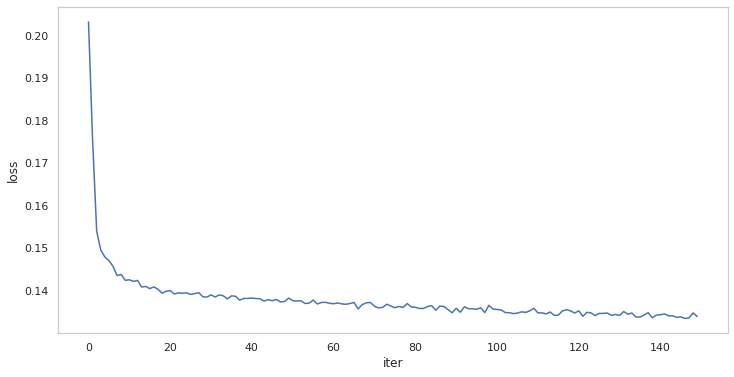

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.plot(train_losses, label='train')
plt.xlabel('iter')
plt.ylabel('loss');

In [ ]:
dataset.save_client_to_indices()

In [ ]:
!zip client_to_indices.zip client_to_indices.p

In [ ]:
!cp client_to_indices.zip '/content/gdrive/MyDrive/courses/hse/3/project/data age group/client_to_indices.zip'

# Train classifier

In [ ]:
# dataset for classifier
# probably can make better
import pickle
SUBSEQUENCE_LENGTH = 90

class ClfAgeDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        seq_length=SUBSEQUENCE_LENGTH,
        root=Path('./data/')
    ):
        super().__init__()
        raw_df = pd.read_csv(root/'transactions_train.csv')

        # NOTE: remapping client_ids to indices
        self.idx2client = raw_df['client_id'].unique()

        raw_df['client_id'] = raw_df['client_id'].map({v: k for k, v in enumerate(self.idx2client)})
        
        self.df = process_transactions(raw_df)
        self.df = self.df.sort_values(['client_id', 'trans_date'])

        self.numerical = torch.from_numpy(self.df.drop('client_id', axis=1).to_numpy()).type(torch.float32)
        self.categorical = torch.from_numpy(self.df[['small_group']].to_numpy()).type(torch.int)

        target_df = pd.read_csv(root/'train_target.csv')
        target_df['client_id'] = target_df['client_id'].map({v: k for k, v in enumerate(self.idx2client)})
        self.target_df = target_df

        self.targets = self.target_df.sort_values('client_id')['bins'].to_numpy()

    def __getitem__(self, idx: int):
        # returns ((numerical, categorical), target_bin)
        n, c = self.get_sequence(idx)
        
        seq_len = len(n)
        start_index = np.random.randint(0, seq_len-SUBSEQUENCE_LENGTH+1)
        end_index = start_index + SUBSEQUENCE_LENGTH
        n = n[start_index:end_index]
        c = c[start_index:end_index]

        return (n, c), self.targets[idx]

    def __len__(self):
        return len(self.client_to_indices)
    
    def get_sequence(self, idx):
        s, e = self.client_to_indices[idx]
        n = self.numerical[s:e]
        c = self.categorical[s:e]
        return n, c
    
    def build_client_to_indices(self):
        self.client_to_indices = {} # tuple of (index start, index after end)
        # so that numpy_array[start:end] yields the sequence
        current = dataset.df.iloc[0, 0]
        start_idx = 0
        print('getting indices', len(self.df))
        for i, (_, r) in tqdm(enumerate(self.df.iterrows())):
            if current != r['client_id']:
                self.client_to_indices[current] = (start_idx, i)
                start_idx = i
                current = r['client_id']
        
        self.client_to_indices[current] = (start_idx, i+1)
    
    def load_client_to_indices(self):
        self.client_to_indices = pickle.load(open("client_to_indices.p", "rb"))
    def save_client_to_indices(self):
        pickle.dump(self.client_to_indices, open("client_to_indices.p", "wb"))

In [ ]:
# freeze encoder
for param in encoder.parameters():
    param.requires_grad = False

encoder.eval();

In [ ]:
clfdataset = ClfAgeDataset()

In [ ]:
clfdataset.load_client_to_indices()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

targets = clfdataset.targets

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

In [ ]:
clfdataloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

In [ ]:
# check
dataiter = iter(clfdataloader)
sequences, labels = dataiter.next()

# should be BATCH_SIZExSUBSEQUENCE_LENGTHx(num_features)
sequences[0].shape, sequences[1].shape

(torch.Size([64, 90, 5]), torch.Size([64, 90, 1]))

In [ ]:
decoder = Decoder(input_dim=EMBEDDING_DIM)
decoder.to(device);

In [ ]:
SCHEDULER_EPOCHS = 2

In [ ]:
optimizer = optim.Adam(decoder.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=SCHEDULER_EPOCHS,
)

In [ ]:
NUM_EPOCHS = 40

In [ ]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

for epoch in tqdm(range(NUM_EPOCHS)):
    decoder.train()
    correct = 0
    epoch_losses = []
    for batch_idx, (sequences, labels) in enumerate(trainloader):
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)

        embeddings = encoder(n, c)
        outputs = decoder(embeddings)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_labels = torch.argmax(outputs, dim=1)
        correct += sum(labels == pred_labels)
        epoch_losses.append(loss.item())

    train_acc = correct / (BATCH_SIZE * len(trainloader))
    epoch_loss = torch.tensor(epoch_losses).mean()
    train_losses.append(epoch_loss)
    train_accuracy.append(train_acc)

    decoder.eval()
    correct = 0
    epoch_val_losses = []
    for batch_idx, (sequences, labels) in enumerate(testloader):
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            embeddings = encoder(n, c)
            outputs = decoder(embeddings)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())

            pred_labels = torch.argmax(outputs, dim=1)
            correct += sum(labels == pred_labels)

    epoch_val_loss = torch.tensor(epoch_val_losses).mean()

    scheduler.step(epoch_val_loss)

    val_losses.append(epoch_val_loss)

    val_acc = correct / (BATCH_SIZE * len(testloader))
    val_accuracy.append(val_acc)
    print(f'Epoch {epoch}, train acc: {train_acc}, val acc: {val_acc}')
    print(f'train loss: {epoch_loss}; val loss: {epoch_val_loss}')

Epoch 0, train acc: 0.5316774249076843, val acc: 0.5540779829025269
train loss: 1.044214129447937; val loss: 0.9950194954872131
Epoch 1, train acc: 0.5520991683006287, val acc: 0.5534130930900574
train loss: 1.001049518585205; val loss: 0.983126699924469
Epoch 2, train acc: 0.5484897494316101, val acc: 0.5634973049163818
train loss: 0.9950850009918213; val loss: 0.9647255539894104
Epoch 3, train acc: 0.5566109418869019, val acc: 0.563054084777832
train loss: 0.9811896681785583; val loss: 0.9686663746833801
Epoch 4, train acc: 0.5534764528274536, val acc: 0.5550753474235535
train loss: 0.9882602691650391; val loss: 0.9713677763938904
Epoch 5, train acc: 0.5529540181159973, val acc: 0.5647162795066833
train loss: 0.9862557649612427; val loss: 0.9695382714271545
Epoch 6, train acc: 0.5643047094345093, val acc: 0.5565159320831299
train loss: 0.971278965473175; val loss: 0.9704612493515015
Epoch 7, train acc: 0.5625, val acc: 0.5575132966041565
train loss: 0.9720007181167603; val loss: 0.96

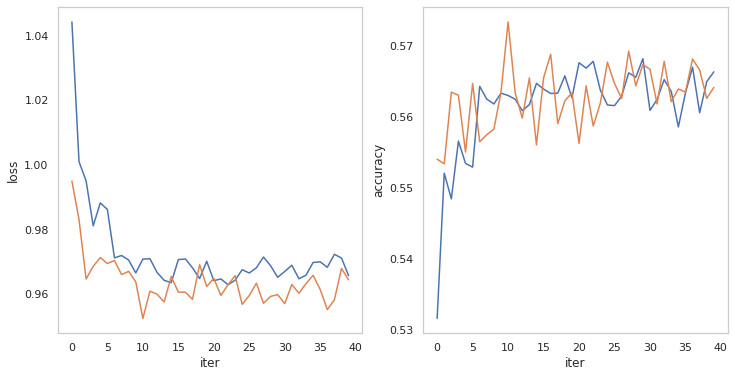

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('iter')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.xlabel('iter')
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='validation')
plt.ylabel('accuracy');

# Predict (old)

In [ ]:
m = encoder.to('cpu').eval()

In [ ]:
# check
dataiter = iter(dataloader)
sequences, labels = dataiter.next()

# should be BATCH_SIZExNUM_OF_SEQUNCESxSUBSEQUENCE_LENGTHx(num_features)
sequences.shape

In [ ]:
embeddings = torch.zeros((1, EMBEDDING_DIM))[1:]

# probably can make it faster if use a batch of clients
for client_id in tqdm(sorted(dataset.targets)):
    n, c = dataset.get_sequence(client_id)

    with torch.no_grad():
        embedding = m(n, c)
        # encoded_events = m.event_encoder(n, c)
        # encoded_events = encoded_events.view(1, -1, EMBEDDING_DIM)
        # encoded_events = torch.transpose(encoded_events, 0, 1) # so that its (seq_len, batch, input_size)
        # embedding = m.sequence_encoder(encoded_events)[0][0]
        embeddings = torch.cat((embeddings, embedding))

embeddings.shape

In [ ]:
X = embeddings.numpy()

# y = dataset.target_df[dataset.target_df['client_id'].isin(dataset.clients)].sort_values('client_id')['bins'].to_numpy()

y = dataset.target_df.sort_values('client_id')['bins'].to_numpy()

In [ ]:
decoder = Decoder(input_dim=EMBEDDING_DIM)
decoder.to(device);

In [ ]:
from catboost import CatBoostClassifier, Pool
from catboost import cv
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=228, stratify=y)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    depth=3,
    learning_rate=0.5,
    verbose=True,
    eval_metric='Accuracy',
    auto_class_weights='Balanced',
    random_state=228,
)

In [ ]:
model.fit(train_pool, eval_set=test_pool)

In [ ]:
train_acc = model.evals_result_['learn']['Accuracy']
valid_acc = model.evals_result_['validation']['Accuracy']

plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
sum(np.squeeze(model.predict(X_test)) == y_test) / len(y_test)